In [1]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
%matplotlib inline

import dipy.data as dpd
import dipy.core.sphere as dps 
import dipy.sims as sims
import dipy.core.gradients as grad
import dipy.core.geometry as geo
import nibabel as nib

In [2]:
fdata, fbval, fbvec = dpd.get_data()
gtab = grad.gradient_table(fbval, fbvec)
gtab.bvals = gtab.bvals/1000. # Make the units work out

/Users/arokem/anaconda3/envs/py2/lib/python2.7/site-packages/dipy/core/gradients.py:132: RuntimeWarning: invalid value encountered in less_equal
  bvecs_close_to_1 = abs(vector_norm(bvecs) - 1) <= atol


In [3]:
data_ni = nib.load(fdata)

In [4]:
data_ni

In [5]:
data = data_ni.get_data()

In [6]:
sph1 = dpd.get_sphere()
#sph1 = dps.Sphere(xyz=[[1,0,0], [0,1,0], [0,0,1]])

In [7]:
def l2norm(vector):
    """ 
    
    
    """
    return vector / np.dot(vector, vector)
    

In [8]:
import dipy.reconst.dti as dti

In [9]:
def single_tensor(evecs, evals, bvec, bval=1, S0=1):
    R = np.asarray(evecs)
    D = np.dot(np.dot(R, np.diag(evals)), R.T)
    return S0 * np.exp(-bval * np.dot(np.dot(bvec, D), bvec.T))

In [10]:
out_dir=np.array([1, 0, 0]) 
evals=np.array([1.5, 0.5, 0.5]) 
bval=1

In [11]:
def out_signal(in_dir, out_dir, evals=np.array([1.5, 0.5, 0.5]), bval=1):
    # Rotate the canonical tensor towards the output direction and  
    # calculate the signal you would have gotten in the direction
    evals = np.asarray(evals)
    canon_tensor = np.array([[evals[0], 0, 0], [0, evals[1], 0], [0, 0, evals[2]]])
    rot_matrix = geo.vec2vec_rotmat(np.array([1,0,0]), out_dir)
    out_tensor = np.dot(rot_matrix, canon_tensor)
    _, evecs = dti.decompose_tensor(out_tensor)
    s = single_tensor(evecs, evals, in_dir, bval=bval, S0=1)    
    return s

In [12]:
def distance_weight(dist, tau=1):
    return np.exp(-dist/tau)

In [13]:
def weighting(location, out_dir, in_dir):
    norm_location = l2norm(location)
    out_corr = np.dot(norm_location, out_dir) 
    in_corr = np.dot(norm_location, in_dir)
    return distance_weight(np.dot(location, location)) * out_corr * in_corr

In [14]:
def design_signal(location, in_dir, out_dir, evals=np.array([1.5, 0.5, 0.5]), bval=1):

    """
    location : the center-to-center location (relative to 0,0,0)
    
    in_dir : observations
    out_dir : parameters
    
    """ 
    this_signal = out_signal(in_dir, out_dir, evals=evals, bval=bval)
    # If you are at the center location:
    if np.all(location == np.array([0, 0, 0])):
        return this_signal
    # Otherwise, we need to downweight by distance and angle 
    else:
        return weighting(location, out_dir, in_dir) * this_signal 

In [15]:
def test_out_signal():
    sig1 = out_signal(np.array([1, 0, 0]), np.array([1, 0, 0]), np.array([1.5, 0.5, 0.5]), 1)
    sig2 = single_tensor(np.eye(3), np.array([1.5, 0.5, 0.5]), np.array([1, 0, 0])) 
    assert sig1 == sig2
              
test_out_signal()

In [16]:
def test_design_signal():
    sig1 = design_signal(np.array([1, 0, 0]), np.array([1, 0, 0]), np.array([1, 0, 0]))
    sig2 = out_signal(np.array([1, 0, 0]), np.array([1, 0, 0]), np.array([1.5, 0.5, 0.5]), 1)

    assert sig1 == sig2

test_out_signal()

In [19]:
dm = ana.design_matrix(gtab, sph1, evals=np.array([1, 0.5, 0.5]))

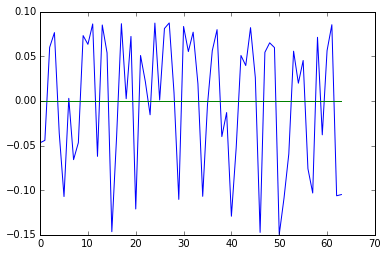

In [20]:
plt.plot(dm[0][:, -1])
plt.plot(dm[1][:, -1])

In [23]:
pp_sig = preprocess_signal(data, gtab, 5, 5, 5)

NameError: global name 'in_dir' is not defined

In [ ]:
plt.plot(np.concatenate(pp_sig))

In [ ]:
new_dm = np.concatenate(dm)
new_sig = np.concatenate(pp_sig)

In [ ]:
import sklearn.linear_model as ElasticNet

In [ ]:
beta, rnorm = opt.nnls(new_dm, new_sig)

In [ ]:
y_hat = np.dot(new_dm, beta)

In [ ]:
plt.scatter(y_hat, new_sig)

In [ ]:
plt.scatter(y_hat[:64], new_sig[:64])
plt.plot([-0.5, 0.5], [-0.5, 0.5], 'k--')

In [ ]:
beta_non, rnorm = opt.nnls(new_dm[:64], new_sig[:64])

In [ ]:
y_hat_non = np.dot(new_dm, beta_non)

In [ ]:
plt.scatter(y_hat_non, new_sig)

In [ ]:
plt.scatter(y_hat_non[:64], new_sig[:64])
plt.plot([-0.5, 0.5], [-0.5, 0.5], 'k--')

In [ ]:
fig, ax = plt.subplots(2)
ax[0].plot(beta_non)
ax[1].plot(beta)

In [ ]:
len(npbeta_non), np.sum(beta)